## Notebook 04

### **1. From Manual Networks to PyTorch – Why Abstract?**

In the last notebook, we **manually implemented**:

- A feedforward neural network (FNN)
- A forward pass to compute predictions
- A backward pass using the chain rule
- Weight updates using **Stochastic Gradient Descent (SGD)**

✅ That helped us build **intuition** for how neural networks learn.

But as we scale up...

> 💡 Real-world models have:
> - Many layers and neurons
> - Millions of weights
> - Complex loss functions
> - Multiple datasets and devices
> - The need for rapid experimentation

Manually coding all that becomes:

❌ Tedious  
❌ Error-prone  
❌ Slow to iterate

**What PyTorch Automates For Us**

| Task                         | Manual (NB03)     | PyTorch (NB04)        |
|------------------------------|-------------------|------------------------|
| Forward pass                 | You wrote it      | Handled by `nn.Module` |
| Gradient computation         | You derived it    | Handled by `autograd`  |
| Weight update (SGD)          | You coded it      | Handled by `optimizer.step()` |
| Loss calculation             | You used MSE      | We’ll use `BCELoss` / `BCEWithLogitsLoss` |
| Batch handling / vector ops  | You looped        | Efficient tensor ops   |


**The Philosophy of Using Frameworks**

We don’t use PyTorch because we *can’t* do it ourselves —  
we use it because it lets us focus on **designing**, **training**, and **improving** models — not on reinventing gradient mechanics.


**What We'll Do in This Notebook**

Now, we’ll build a similar FNN using PyTorch tools:

- Load and preprocess the **Heart Disease dataset**
- Define a model using `nn.Module` or `nn.Sequential`
- Train it using `BCEWithLogitsLoss` and `Adam` optimizer
- Evaluate performance and visualize results

**What You'll Learn**

- How to define a deep learning model with PyTorch
- How to preprocess real-world tabular data
- How to train, monitor, and evaluate a binary classifier
- How to bridge theory → practice

---

### **2. Dataset Preparation – Heart Disease Data**

Before we train a PyTorch model, we need to **load**, **clean**, and **prepare** the Heart Disease dataset.

**About the Dataset**

This dataset comes from the **UCI Machine Learning Repository** and contains:

- **Patient characteristics** (e.g., age, sex, cholesterol)
- **Medical test results**
- A **target label** (`num`) indicating presence or absence of heart disease

**Goal for This Notebook**

We’ll perform **binary classification**:  
Does a person have heart disease?

Let’s **simplify the target** into 2 classes:

- `0` → No disease  
- `1` → Disease present (merge 1, 2, 3, 4)

In [20]:
import pandas as pd

# Load data
df = pd.read_csv("heart.csv")
print(df.shape)
print(df.head())

(303, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    2  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0  


**Check for Missing Values**

In [2]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

We will drop rows with missing values to keep things simple.

In [21]:
df = df.dropna()
print("Remaining rows:", df.shape[0])

Remaining rows: 297


**Simplify the Target**

We will convert `num` (0–4) into a binary label.

In [4]:
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df['target'].value_counts()

target
0    160
1    137
Name: count, dtype: int64

**Select Features**

We’ll use **all 13 input columns** (excluding the original `num`),  
and predict the new `target`.

In [5]:
X = df.drop(columns=['num', 'target'])
y = df['target']

**Normalize the Input Features**

To improve training, we **standardize** input features (mean = 0, std = 1).

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Train/Test Split**

Let’s split the dataset into:
- 80% training
- 20% testing

In [22]:
from sklearn.model_selection import train_test_split
import torch

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 237
Test size: 60



✅ We now have a fully cleaned, scaled, and split dataset — ready to be used in a PyTorch model!

➡️ In the next section, we’ll define our **Feedforward Neural Network** model architecture using `nn.Sequential`.

---

### **3. Defining the Model using `nn.Sequential`**

Now that we’ve prepared our dataset, let’s define a **Feedforward Neural Network (FNN)** using PyTorch.

**Architecture Overview**

We’ll build a simple network:

- Input: 13 features (from the dataset)
- Hidden layer: 16 neurons with ReLU activation
- Output: 1 neuron (for binary prediction)

📝 We’ll use **`nn.Sequential`** to define this model concisely.

**Define FNN with `nn.Sequential`**

In [23]:
import torch.nn as nn

# Define model
model = nn.Sequential(
    nn.Linear(13, 16),   # Input layer → Hidden layer (13 → 16)
    nn.ReLU(),           # Activation
    nn.Linear(16, 1),    # Hidden → Output layer (16 → 1)
    nn.Sigmoid()         # Output activation for binary classification
)

# Show architecture
print(model)

Sequential(
  (0): Linear(in_features=13, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
  (3): Sigmoid()
)


**Why `Sigmoid` at the Output?**

- Because we want the model’s output to be a **probability** between 0 and 1.
- This matches with the **binary target labels** (0 or 1).
- We’ll later use **`BCELoss`** which expects probabilities.

**Parameter Count**

- Layer 1 (Linear 13 → 16): 13 × 16 weights + 16 biases = 224
- Layer 2 (Linear 16 → 1): 16 weights + 1 bias = 17
- **Total trainable parameters** = 241

➡️ You can confirm this using:

In [24]:
sum(p.numel() for p in model.parameters())

241

**Summary**

- Defined a 2-layer FNN with ReLU and Sigmoid
- Chose `nn.Sequential` for clarity and simplicity

➡️ Next, we’ll define the **loss function and optimizer** to begin training.

---

### **4. Loss Function and Optimizer**

Now that we have defined our FNN model, we need to specify **how the model learns** from the data.

This requires:

1. A **loss function**: to measure the model's prediction error  
2. An **optimizer**: to update the model’s weights using gradients

**Loss Function: `nn.BCELoss`**

We are doing **binary classification**, so we’ll use:

In [10]:
loss_fn = nn.BCELoss()

**Why `BCELoss`?**

- It expects model outputs to be **probabilities** (which we get from `Sigmoid`)
- It compares predicted probabilities with true binary labels (0 or 1)

**Optimizer: `torch.optim.Adam`**

For training the model, we use the **Adam** optimizer:

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

**Why `Adam`?**

- Adaptive learning rate for each parameter
- Generally works well as a default choice
- Less sensitive to initial learning rate

**Define Loss and Optimizer**

In [25]:
import torch.optim as optim

# Loss function: Binary Cross-Entropy
loss_fn = nn.BCELoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("Loss function:", loss_fn)
print("Optimizer:", optimizer)

Loss function: BCELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


### **What Happens Behind the Scenes?**

1. The model makes a prediction: $\hat{y}$  
2. The loss compares $\hat{y}$ with the true label $y$  
3. Gradients are computed via **backpropagation**  
4. The optimizer updates the weights to reduce the loss

We’ll soon put all this together in the **training loop**.

➡️ Let’s now write the full **training loop** to train our FNN on the dataset.

---

### **5. Training the Model (Looping Over Epochs)**

Now that we have:

- ✅ Defined our model (`nn.Sequential`)
- ✅ Chosen a loss function (`BCELoss`)
- ✅ Configured the optimizer (`Adam`)

…it’s time to **train the model** using the **forward → loss → backward → update** cycle.

**Training Steps Recap:**

For each epoch:

1. **Forward pass** → Compute predictions from input features
2. **Loss computation** → How far are we from the true labels?
3. **Backward pass** → Compute gradients w.r.t. weights
4. **Parameter update** → Optimizer steps in and adjusts weights
5. **Zero gradients** → Reset before the next epoch

**Epochs and Tracking Loss**

- We’ll train for **100 epochs**
- Store all training losses in a Python list
- Print loss every **10 epochs** to monitor progress

### Training Loop

In [26]:
# Number of epochs
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save loss
    train_losses.append(loss.item())

    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/200], Loss: 0.5094
Epoch [20/200], Loss: 0.3889
Epoch [30/200], Loss: 0.3521
Epoch [40/200], Loss: 0.3267
Epoch [50/200], Loss: 0.3117
Epoch [60/200], Loss: 0.2965
Epoch [70/200], Loss: 0.2810
Epoch [80/200], Loss: 0.2643
Epoch [90/200], Loss: 0.2448
Epoch [100/200], Loss: 0.2232
Epoch [110/200], Loss: 0.2007
Epoch [120/200], Loss: 0.1777
Epoch [130/200], Loss: 0.1560
Epoch [140/200], Loss: 0.1364
Epoch [150/200], Loss: 0.1194
Epoch [160/200], Loss: 0.1050
Epoch [170/200], Loss: 0.0924
Epoch [180/200], Loss: 0.0817
Epoch [190/200], Loss: 0.0727
Epoch [200/200], Loss: 0.0650


**Why Are We Doing This?**

This loop helps the model **gradually learn** by adjusting weights over many passes through the data.

> As loss goes down, predictions should get closer to the true values (0 or 1).

In the next section, we’ll **plot the training loss** to visualize learning progress over time.

---

### **6. Plotting the Loss Curve**

After training the model, let’s **visualize how the loss decreased over time**.

**Why?**

- Helps us **diagnose** if the model is learning properly
- See if loss **plateaus too early** or decreases smoothly
- Understand how the **optimizer is working**

**What to Look For**

- A **downward trend** over epochs is a good sign
- If the curve is very **flat**, maybe learning rate is too low
- If the loss **jumps around**, try lower learning rate or more data

**Plot the Training Loss**

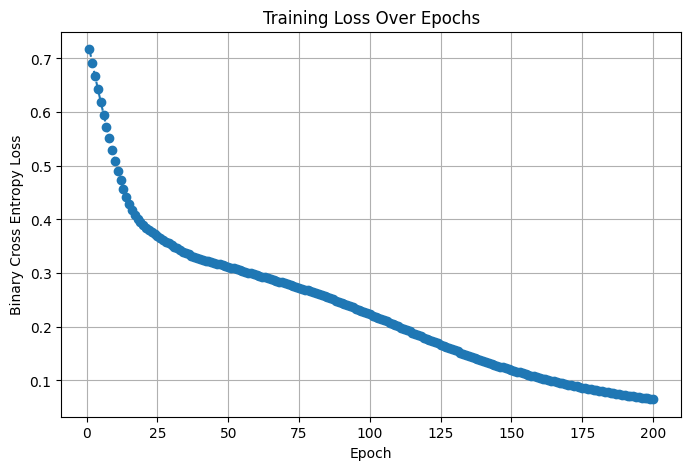

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, linestyle='--', marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.grid(True)
plt.show()

In [28]:
# predicting based on train set
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)
    y_train_pred = (y_train_pred > 0.5).float()

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

confusion_matrix(y_train, y_train_pred)

array([[123,   1],
       [  3, 110]], dtype=int64)

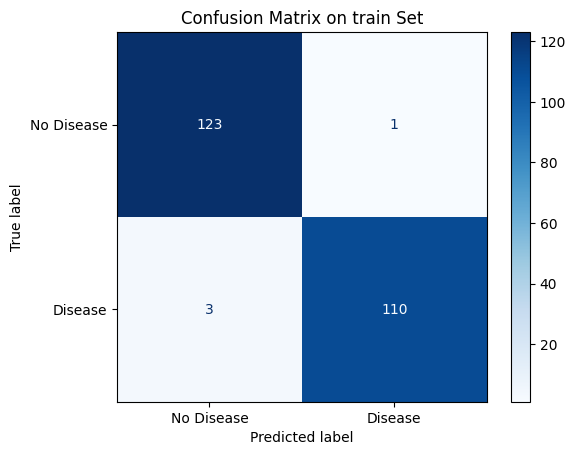

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on train Set")
plt.grid(False)
plt.show()


In [36]:
from sklearn.metrics import accuracy_score

# Put model in evaluation mode
model.eval()

# Turn off gradient tracking
with torch.no_grad():
    y_train_logits = model(X_train)
    y_train_probs = torch.sigmoid(y_train_logits)
    y_train_preds = (y_train_probs >= 0.5).float()  # threshold at 0.5

    # Compute test loss
    train_loss = loss_fn(y_train_logits, y_train)

# Accuracy
train_acc = accuracy_score(y_train.numpy(), y_train_preds.numpy())

print(f"Train Loss: {train_loss.item():.4f}")
print(f"Train Accuracy: {train_acc * 100:.2f}%")

Train Loss: 0.0643
Train Accuracy: 47.68%


**What This Tells Us**

A **smoothly decreasing loss** suggests that:

- The model is learning useful patterns from the training data
- The optimizer (Adam) and learning rate are appropriate
- We’re likely not underfitting or overfitting — yet


> 🔔 Later, we’ll compare this to the **test loss** and accuracy to see how well the model generalizes to unseen data.

➡️ Next: Let’s **evaluate the model** on the test set and analyze its performance!

---

### **7. Evaluating the Model on Test Set**

Now that we’ve trained our neural network and visualized its training loss, let’s evaluate how well it performs on **unseen data** — the **test set**.

**Goals:**

- Compute **test loss**
- Measure **accuracy**
- Show a **confusion matrix**
- Interpret what the numbers mean

**Key Concept: Generalization**

> A good model should perform **well not just on training data**,  
> but also on **new, unseen test data**.

**Evaluate the Model**

In [37]:
# Put model in evaluation mode
model.eval()

# Turn off gradient tracking
with torch.no_grad():
    y_test_logits = model(X_test)
    y_test_probs = torch.sigmoid(y_test_logits)
    y_test_preds = (y_test_probs >= 0.5).float()  # threshold at 0.5

    # Compute test loss
    test_loss = loss_fn(y_test_logits, y_test)

# Accuracy
test_acc = accuracy_score(y_test.numpy(), y_test_preds.numpy())

print(f"Test Loss: {test_loss.item():.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Loss: 0.6267
Test Accuracy: 40.00%


**Confusion Matrix**

The **confusion matrix** shows how many samples were:

- **Correctly classified** (True Positives and True Negatives)
- **Incorrectly classified** (False Positives and False Negatives)

**Plot Confusion Matrix**

In [38]:
# predicting based on train set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

confusion_matrix(y_test, y_test_pred)

array([[30,  6],
       [ 3, 21]], dtype=int64)

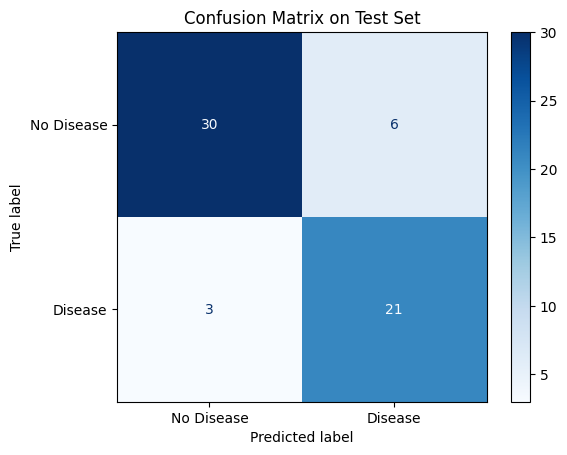

In [39]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

**Interpretation:**

- High values on the **diagonal** = good!
- Off-diagonal values suggest **misclassifications**
- This helps us understand **model strengths and weaknesses**

> ✅ If your model shows decent accuracy and balanced predictions, that means it has **learned to generalize** — not just memorize.

➡️ In the final section, we’ll reflect on the full process and look ahead to deeper models in the next project.

---

### **8. Reflection + What’s Next**

You’ve now completed a **full deep learning pipeline** — from scratch to PyTorch training —  
on a real-world binary classification task. 🎉

**What We Built in This Notebook**

✅ Defined an FNN using PyTorch’s `nn.Sequential` or `nn.Module`  
✅ Used **BCEWithLogitsLoss** for binary classification  
✅ Trained using **Adam** optimizer  
✅ Visualized the **training loss curve**  
✅ Evaluated test set performance with **accuracy** and **confusion matrix**

**What You Should Now Understand:**

- How to structure a neural network in PyTorch
- How loss and optimization work in practice
- How to use sigmoid activation for binary outputs
- What generalization means and how to assess it
- How to connect training curves and model performance

**Limitations of Our Current Model**

- **No regularization** → May overfit with more layers or longer training  
- **Small architecture** → Limited ability to capture very complex patterns  
- **Manual tuning** of learning rate and size → Suboptimal performance

These are exactly the **challenges we’ll address next**.

**What’s Coming in Project 3: Training Neural Networks**

> “We now know how to build and train a model —  
> next, we learn how to train it **better**.”

In the next project, we’ll explore:

| Topic                    | Why It Matters                                               |
|--------------------------|--------------------------------------------------------------|
| **Optimizers**        | Learn the math and behavior behind SGD and Adam              |
| **Loss Functions**    | MSE vs. Cross-Entropy — when to use which                    |
| **Regularization**   | Techniques like Dropout and L2 to prevent overfitting        |
| **Mini-batching**     | Train faster and more robustly with batch-wise updates       |
| **Advanced Training** | Tips for convergence, learning rate tuning, and early stopping |


**Repetition + Transfer**

Much of the logic you saw here will **repeat** —  
but we’ll **build upon it**, and learn how to make training:

- More efficient
- More stable
- More robust

**Final Words**

You’ve now seen:

- Linear models (NB01)
- Non-linear FNNs (NB02)
- Manual backpropagation (NB03)
- Full PyTorch training (NB04)

> You’re now fully equipped to **train deep models**.  
> In the next project, we’ll learn to train them **smartly**.